# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset

Advanced Topics in Machine Learning -- Fall 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


During this first *challenge* of the *Advanced Machine Learning Course*, you will experiment with the development of a data analysis pipeline based upon various techniques seen during the lectures so far: some **unsupervised** (*e.g.* *PCA*, *kernel-PCA*) and some others **supervised** (*e.g.* *kernel SVM* and *Artificial Neural Networks* for classification).

### The dataset

The dataset of interest for the *challenge* will be [*FashionMNIST*](https://github.com/zalandoresearch/fashion-mnist), an *MNIST*-like dataset of grayscale images of fashion items. Originally developed by Zalando Research in 2017 as a harder (yet *drop-in* compatible) replacement for the original *MNIST* dataset, it has been used in several papers and competitions since then.

Remember to consider the *dataset* mentioned below as the **training set** offered by *FashionMNIST*. Use the *test set* only at the end, to evaluate the overall accuracy of the pipeline!

### Section 1: Understanding data geometry

Load the dataset in the most suitable form for the tasks that follow. Then, perform the following steps, with the goal of developing a geometric understanding of the dataset:

1. Perform a (linear) *PCA* on the dataset, and plot the first two (or three!) principal components along with the true label. Comment on data separation.

2. Perform a *kernel-PCA* on the dataset with a Gaussian kernel, and plot the first two (or three!) principal components along with the true label. Try to tune the dispersion parameter of the kernel to obtain a good separation of the data. Comment.

3. Perform another *kernel-PCA* on the dataset with another kernel of your own choice, and plot the first two (or three!) principal components along with the true label. Try to tune the degree of the polynomial kernel to obtain a good separation of the data. Comment.

Whenever suitable, try to complement your analysis with some graphs!

**IMPORTANT NOTICE**: As some of you have reported, performing *kernel PCA* on the entire *FashionMNIST* dataset can be memory- and time- demanding (as it scales with the square of the number of datapoints!). In case you want to reduce such requirements, you can either:
  - Reduce the number of datapoints on which to perform *kPCA*, *e.g.* by slicing the randomly-shuffled dataset *(most effective!)*;
  - Reduce the size of the images in the dataset (*i.e.* by dropping even/odd rows/columns, or performing local pooling) *(somehow effective: you may want to try it if you do not have access to powerful compute, but still enjoy challenges!)*.

In [1]:
# !pip install jax

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Run this if you don't have a GPU
jax.config.update('jax_platform_name', 'cpu')

In [2]:
# First, we load the Fashion MNIST dataset using PyTorch
transform = transforms.Compose([transforms.ToTensor()])
fashion_mnist = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Quick trick for getting the whole dataset as a single batch
dataloader = DataLoader(fashion_mnist, batch_size=len(fashion_mnist), shuffle=True) # we shuffle for next cells

fashion_mnist_classes = fashion_mnist.classes
del fashion_mnist

X_train, y_train = next(iter(dataloader))

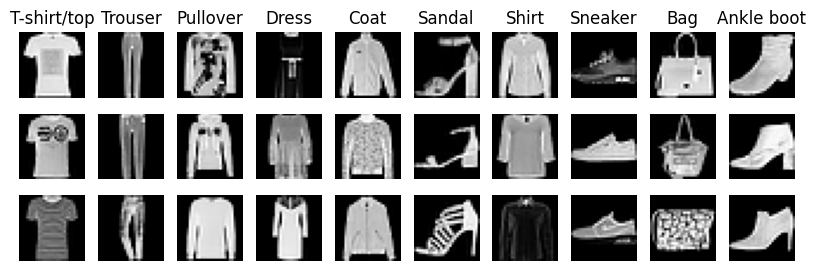

: 

In [3]:
# Plot 3 x 10 unique label images
item_2_class = {i: c for i, c in enumerate(fashion_mnist_classes)}

fig, ax = plt.subplots(3, 10, figsize=(10, 3))
for i in range(10):
    ax[0, i].set_title(item_2_class[i])
    for j in range(3):
        ax[j, i].imshow(X_train[y_train == i][j].squeeze(), cmap='gray')
        ax[j, i].axis('off')
        
plt.show()

In [4]:
# Data preparation
X_train = jax.device_put(X_train.view(X_train.shape[0], -1).numpy())
y_train = jax.device_put(y_train.numpy())

def standardize(X):
    # we use this also to normalize wrt the dimensionality of the input
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0) + 1e-8
    X = (X - X_mean) / (X_std)
    # if a value is greater than 100 in absolute value, we set it to zero
    X = jnp.where(jnp.abs(X) > 100, 0, X)
    
    return X/jnp.sqrt(X.shape[1]), X_mean, X_std

X_train_scaled, X_mean, X_std = standardize(X_train) # Important especially for PCA

print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

In [6]:
# Start with Linear PCA, with n_components=3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scaled) # Projected X_train_scaled

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.22194062 0.14486611 0.05488495]
Total variance explained: 0.4216917


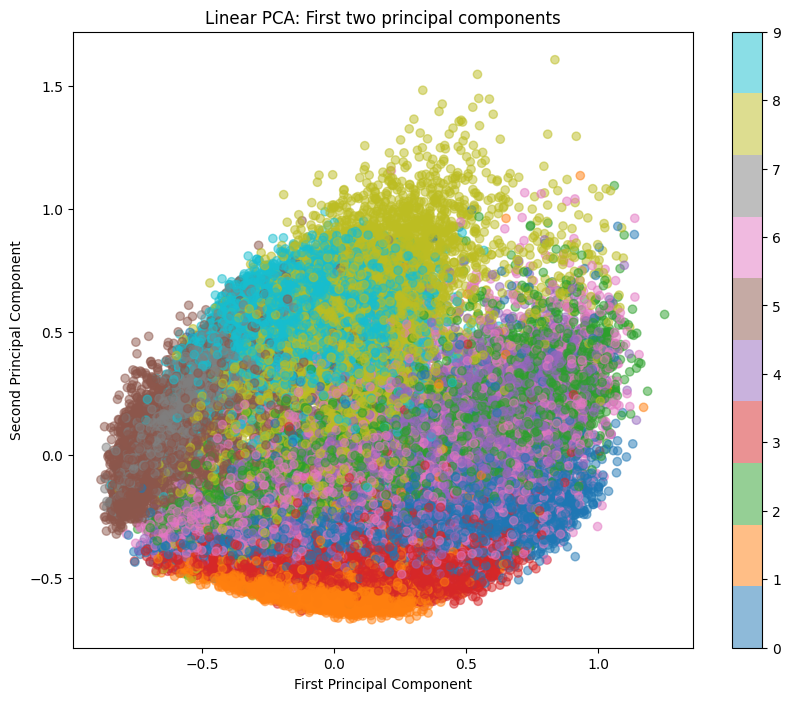

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [7]:
# First plot (2D)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='tab10', alpha=0.5)
plt.colorbar(scatter)
plt.title("Linear PCA: First two principal components")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()
print(item_2_class)

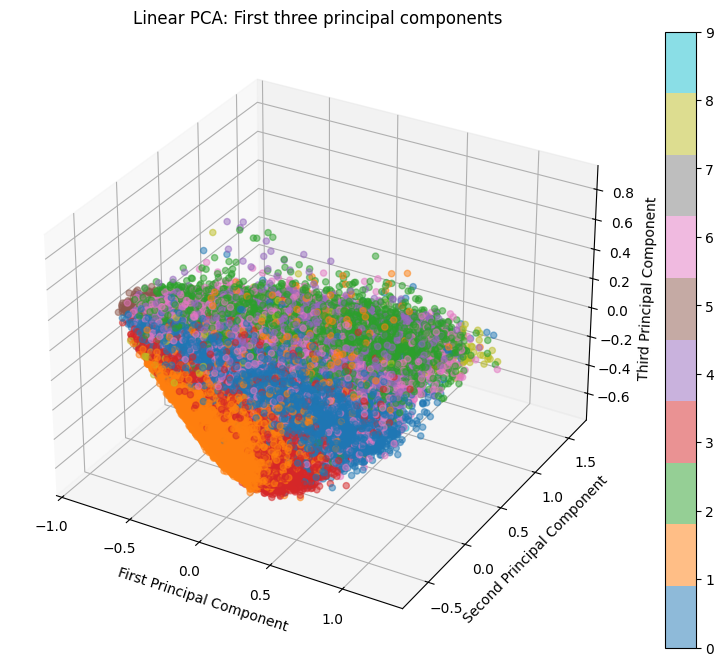

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [8]:
# 3D Plot for the first three principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_train, cmap='tab10', alpha=0.5)
plt.colorbar(scatter)
plt.title("Linear PCA: First three principal components")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_zlabel("Third Principal Component")
plt.show()

print(item_2_class)

## Some observations

### Overall distribution:
The projected classes are superposed indicating that they are not perfectly separable using linear PCA. This suggests that the Fashion MNIST dataset has probably complex, non-linear relationships between classes.

I want to set your attention on the data preparation (standardizer):

- First, we standardize the features;
- Then, we remove outliers (they might be present if the std is zero, especially in the corners where the signal is always uniform);
- Finally, we scale wrt the sqrt of the dimensionality of the data: if we change the resolution of the image the variance associated to scalar products might change too, instead I wanted to normalize also wrt that.

### Specific observations on clusters
- The orange cluster (Trousers) is quite distinct, you can see it right in the 2D plot. This suggests that trousers have features that set them apart from other clothing items;

- The class in grey (Sneaker) overlaps with 5 (Sandal), and 9 (Ankle); that makes sense, and it's something we can expect;

- Classes blue (T-shirt/top), green (Pullover), purple (Coat), and pink (Shirt) seem to have considerable overlap. This makes sense as they are all upper body clothes with similar shapes

- The whole data is centered in zero, so the classes are a bit in opposition (plot in 2D);

- In 3D plot we see that is still overlapping, so we need more dimensions to correctly separate the data;

Now, let's proceed with Kernel PCA (Gaussian), and see if something changes

In [9]:
# We keep only 1/20 of the data due to computational constraints of Kernel PCA
X_train, y_train = next(iter(dataloader))
X_train = X_train[:X_train.shape[0] // 20]
y_train = y_train[:y_train.shape[0] // 20]

X_train = jax.device_put(X_train.view(X_train.shape[0], -1).numpy())
y_train = jax.device_put(y_train.numpy())
X_train_scaled = standardize(X_train)

print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

X_train shape: (3000, 784)
y_train shape: (3000,)


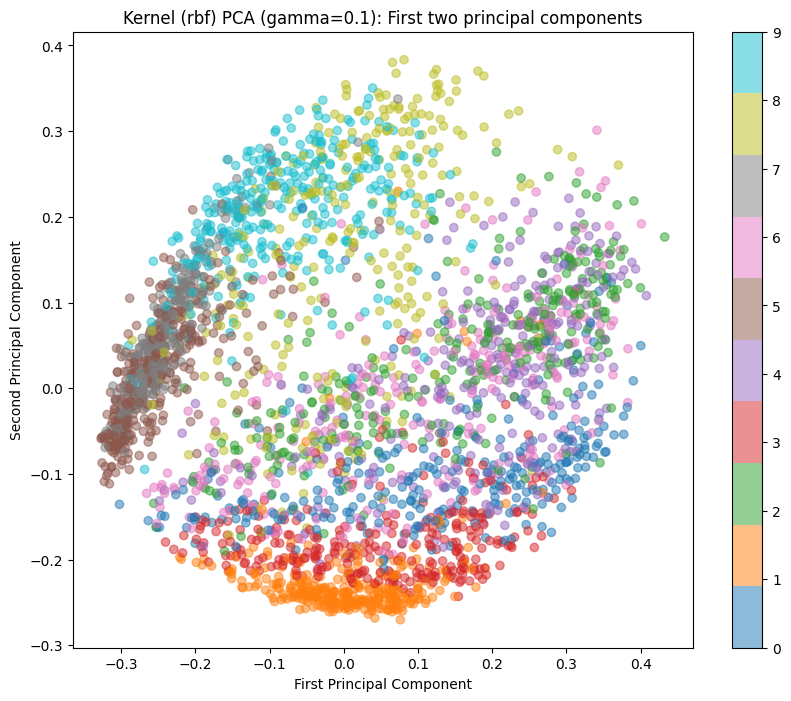

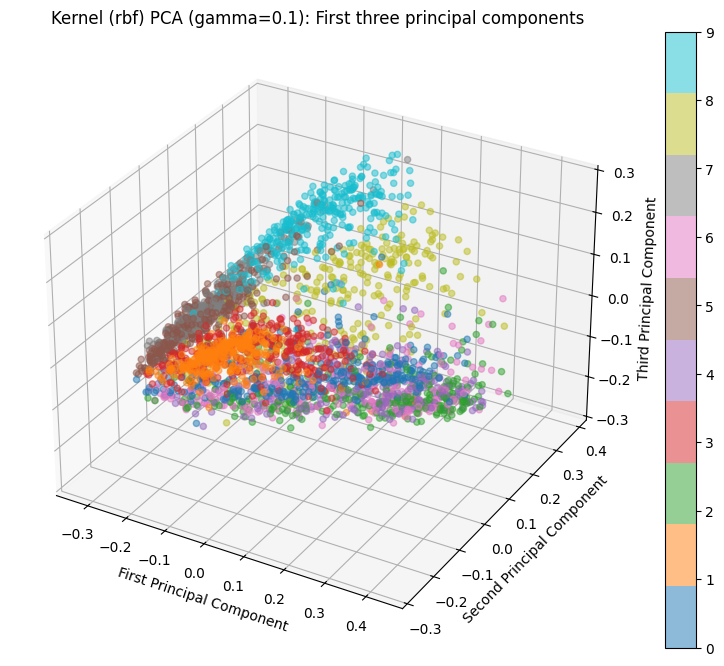

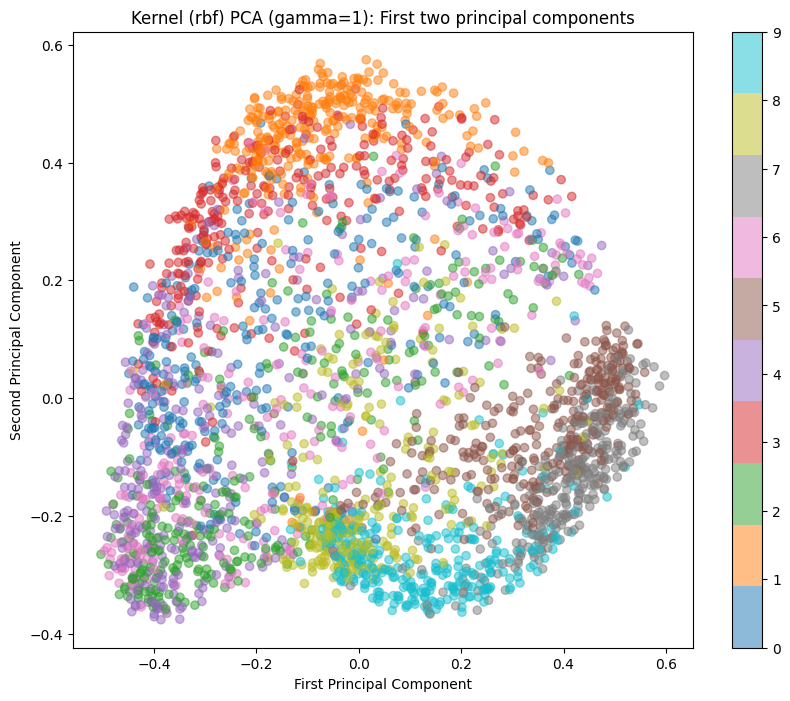

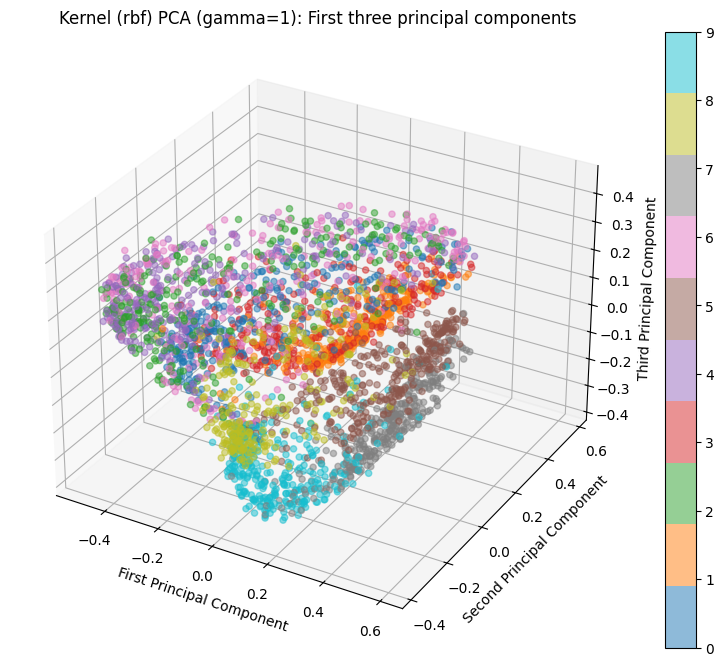

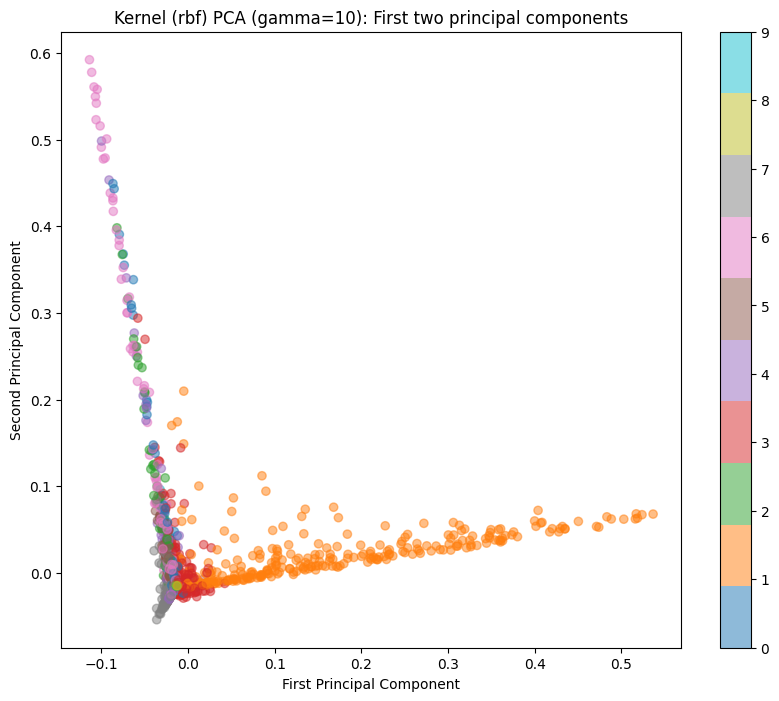

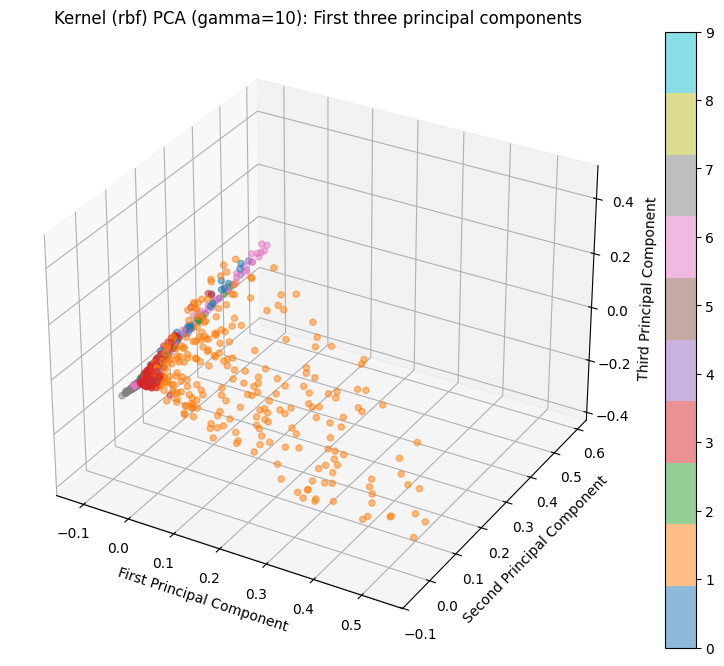

In [10]:
from sklearn.decomposition import KernelPCA

def plot_kernel_pca_rbf(X, y, gamma):
    kpca = KernelPCA(n_components=3, kernel='rbf', gamma=gamma, fit_inverse_transform=True)
    X_kpca = kpca.fit_transform(X)
    # Plot the first two principal components
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(f"Kernel (rbf) PCA (gamma={gamma}): First two principal components")
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.show()

    # Plot the first three principal components
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_kpca[:, 0], X_kpca[:, 1], X_kpca[:, 2], c=y, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(f"Kernel (rbf) PCA (gamma={gamma}): First three principal components")
    ax.set_xlabel("First Principal Component")
    ax.set_ylabel("Second Principal Component")
    ax.set_zlabel("Third Principal Component")
    plt.show()

gammas = [0.1, 1, 10]
for gamma in gammas:
    plot_kernel_pca_rbf(X_train_scaled, y_train, gamma)

## Some observations

In my opinion the best value of gamma for the rbf kernel is 1.0, this because it is a good trade off between 0.001 (too small, it's basically a standard PCA), and 10 (overfitting, no clear separation); we can see that also in this case there is superposition of classes, especially in the 2 dimensional case.

Moreover, you can see that some of the hypotesis we made for the linear PCA holds also in the non-linear case (labels 5, 7, and 9 are still near in the manifold).

Now, let's try with polynomial kernel

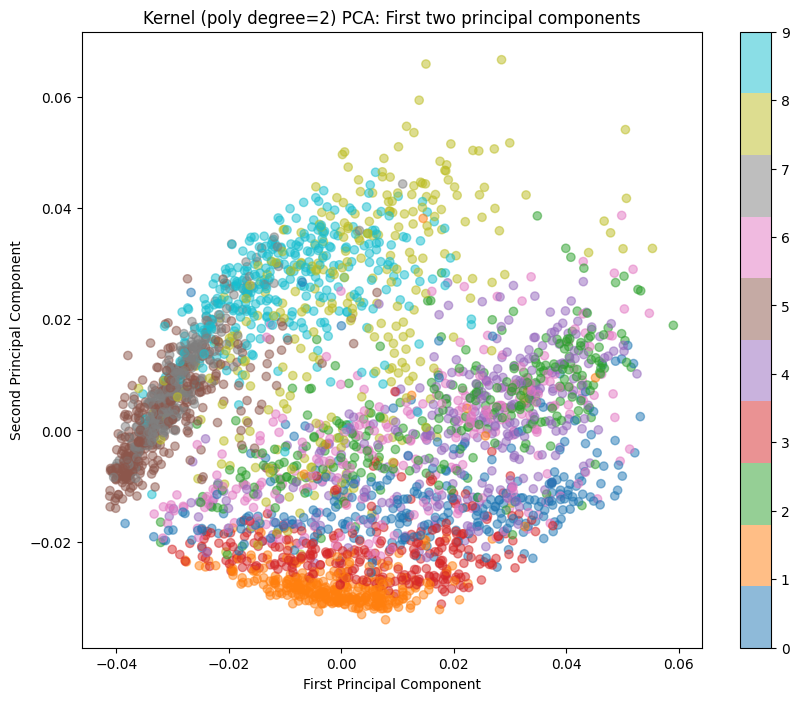

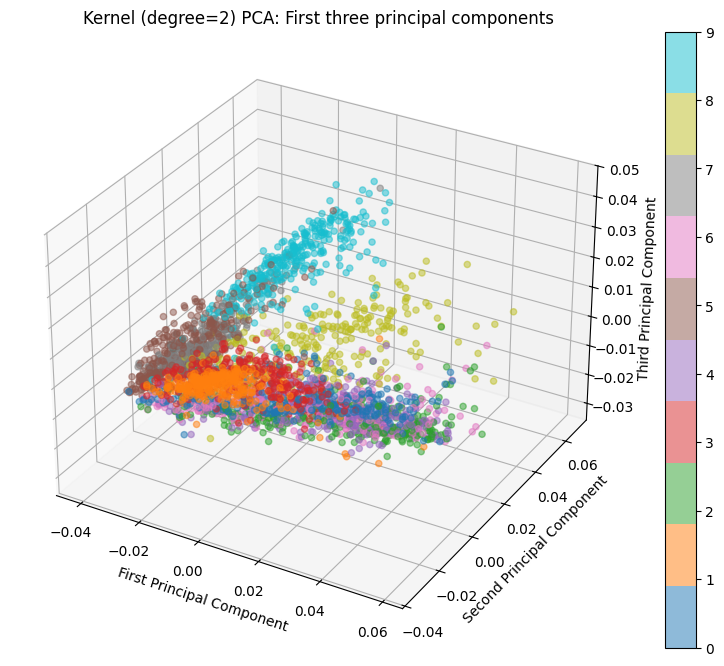

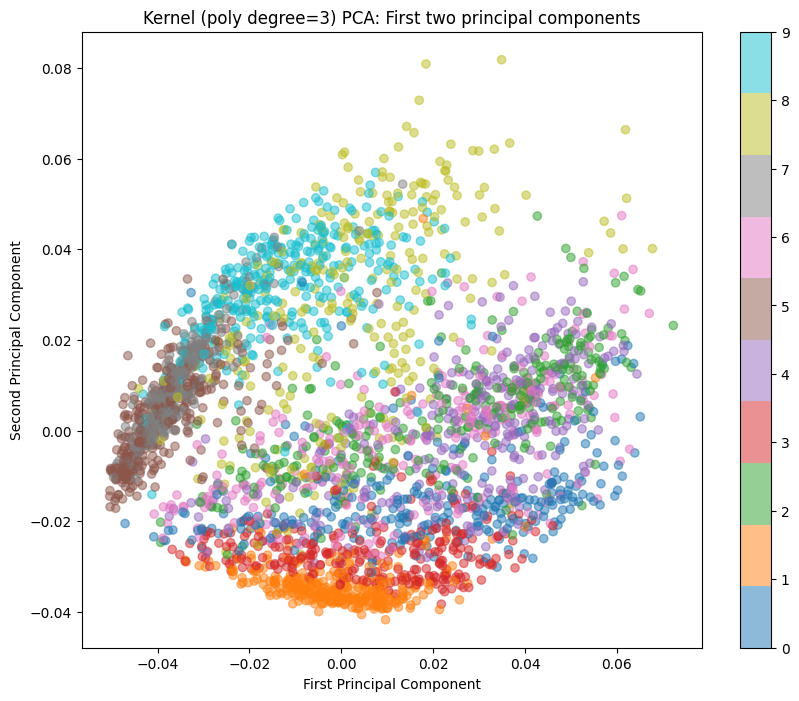

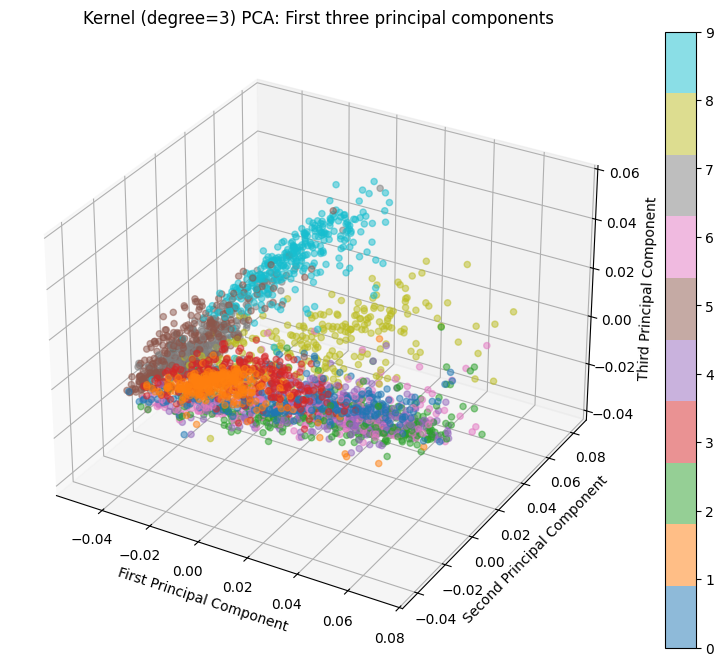

In [11]:
def plot_kernel_pca_poly(X, y, degree):
    kpca = KernelPCA(n_components=3, kernel='poly', degree=degree, coef0=1, fit_inverse_transform=True)
    X_kpca = kpca.fit_transform(X)
    # Plot the first two principal components
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(f"Kernel (poly {degree=}) PCA: First two principal components")
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.show()

    # Plot the first three principal components
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_kpca[:, 0], X_kpca[:, 1], X_kpca[:, 2], c=y, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(f"Kernel ({degree=}) PCA: First three principal components")
    ax.set_xlabel("First Principal Component")
    ax.set_ylabel("Second Principal Component")
    ax.set_zlabel("Third Principal Component")
    plt.show()

degs = [2, 3]
for deg in degs:
    plot_kernel_pca_poly(X_train_scaled, y_train, degree=deg)

## Some observations

We can see that also polynomial kernel can separate features, the degree 2 is ok because there are no messive changes if we increase it:

- To capture the complexity of the data we may need degree 2 but with some more dimensions we don't need too much complex feature maps;
- Maybe the data is effectively noisy, and some concepts are not so well defined and separated also in 3 dimensions (the core features are shared, and there is difference only in the high order components);
- We can see that green and purple classes are hard to separate (as we expected);
- Important: these plots exists because I normalized wrt the dimension of the data, I tried without it, and it blows up for degree 3, and 4 -> this kernel is very sensitive to data preparation, as we expect from its definition

### Section 2: Bridging *unsupervised* and *supervised*

Choose one of the results obtained in the previous section (you should choose the one better explaining data geometry), and ignore the true labels. Then, perform the following steps:

1. Considering only the first $10$ components of the *(kernel-)PCA* and try to assign $10$ labels to the resulting datapoints. Choose the approach you deem most suitable. Comment on the results, by considering:
    
    a. How well does the label-assignment just performed reflect the true labels?

    b. Does the number of components used ($10$) reflect the actual *knee-* or *gap-* *point* of the spectrum associated to the principal components?

Whenever suitable, try to complement your analysis with some graphs!

In [12]:
# We keep only 1/20 of the data due to computational constraints of Kernel PCA
X_train, y_train = next(iter(dataloader))
X_train = X_train[:X_train.shape[0] // 20]
y_train = y_train[:y_train.shape[0] // 20]

X_train = jax.device_put(X_train.view(X_train.shape[0], -1).numpy())
y_train = jax.device_put(y_train.numpy())
X_train_scaled = standardize(X_train)

print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

X_train shape: (3000, 784)
y_train shape: (3000,)


Adjusted Rand Index: 0.36168679521554564


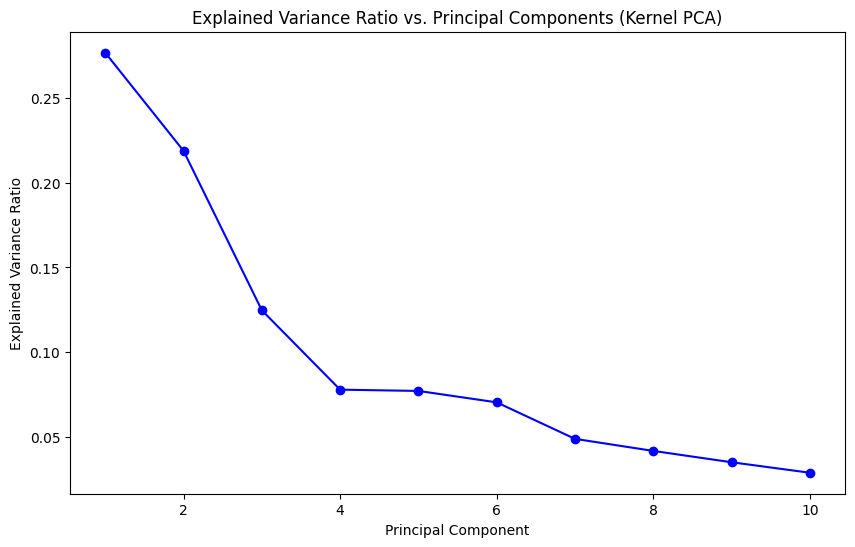

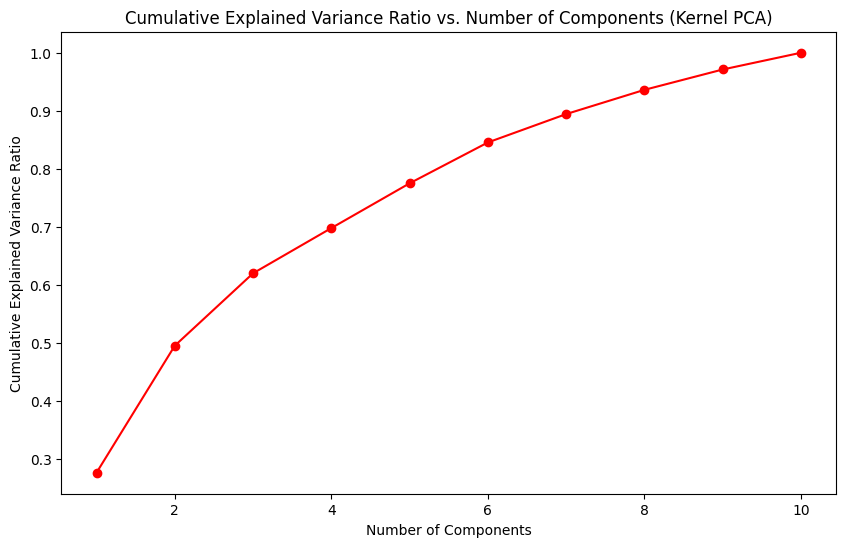

In [24]:
# We choose Kernel PCA with RBF kernel, gamma=1.0 and n_components=10
kpca = KernelPCA(n_components=10, kernel='rbf', gamma=1.0, fit_inverse_transform=True)
X_kpca = kpca.fit_transform(X_train_scaled)

# Let's use KMeans to cluster the data in the Kernel PCA space to understand the main clusters
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score # Adjusted Rand Index

kmeans = KMeans(n_clusters=10, random_state=0)
cluster_labels = kmeans.fit_predict(X_kpca)

ari = adjusted_rand_score(y_train, cluster_labels)

print(f"Adjusted Rand Index: {ari}")

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), kpca.eigenvalues_ / kpca.eigenvalues_.sum(), 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Principal Components (Kernel PCA)')
plt.show()

# Calculate cumulative explained variance
cumulative_variance_ratio = jnp.cumsum(kpca.eigenvalues_) / kpca.eigenvalues_.sum()
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cumulative_variance_ratio, 'ro-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components (Kernel PCA)')
plt.show()

For better inspection of the classes, let's use a Sankey Diagram

In [25]:
import pandas as pd
import plotly.graph_objects as go

df = pd.DataFrame({'true_label': y_train, 'cluster': cluster_labels})

# Count the occurrences of each true label in each cluster
counts = df.groupby(['cluster', 'true_label']).size().reset_index(name='count')

source = counts['cluster']
target = counts['true_label'] + 10  # Offset target by 10 to separate from source
value = counts['count']

# Create labels for clusters and true classes
c_labels = [f'Cluster {i}' for i in range(10)]
true_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
labels = c_labels + true_labels

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue"
    ),
    link = dict(
      source = source,
      target = target,
      value = value
  ))])

fig.update_layout(title_text="Cluster to True Label Flow", font_size=10)
fig.show()

print("\nCluster to True Label Distribution:")
for cluster in range(10):
    cluster_data = counts[counts['cluster'] == cluster]
    total = cluster_data['count'].sum()
    print(f"\nCluster {cluster}:")
    for _, row in cluster_data.iterrows():
        percentage = (row['count'] / total) * 100
        print(f"  {true_labels[row['true_label']]}: {percentage:.2f}%")


Cluster to True Label Distribution:

Cluster 0:
  T-shirt/top: 16.51%
  Trouser: 1.90%
  Pullover: 24.13%
  Dress: 4.44%
  Coat: 13.65%
  Sandal: 0.32%
  Shirt: 30.48%
  Bag: 8.57%

Cluster 1:
  T-shirt/top: 6.08%
  Trouser: 0.95%
  Pullover: 4.75%
  Dress: 1.14%
  Coat: 1.90%
  Sandal: 8.56%
  Shirt: 6.46%
  Sneaker: 0.38%
  Bag: 47.72%
  Ankle boot: 22.05%

Cluster 2:
  T-shirt/top: 1.13%
  Trouser: 0.57%
  Pullover: 39.38%
  Coat: 39.66%
  Shirt: 18.70%
  Bag: 0.57%

Cluster 3:
  Sandal: 23.57%
  Sneaker: 72.14%
  Bag: 1.79%
  Ankle boot: 2.50%

Cluster 4:
  T-shirt/top: 5.86%
  Trouser: 8.59%
  Dress: 73.83%
  Coat: 3.52%
  Shirt: 3.12%
  Bag: 5.08%

Cluster 5:
  T-shirt/top: 8.33%
  Trouser: 4.37%
  Pullover: 9.13%
  Dress: 26.19%
  Coat: 34.92%
  Shirt: 14.68%
  Bag: 2.38%

Cluster 6:
  Sandal: 8.47%
  Sneaker: 14.92%
  Bag: 2.02%
  Ankle boot: 74.60%

Cluster 7:
  T-shirt/top: 83.15%
  Dress: 4.35%
  Shirt: 12.50%

Cluster 8:
  T-shirt/top: 7.55%
  Trouser: 1.89%
  Pullover: 6.

## Some observations

- The ARI score is between 0.35, and 0.40, that indicates that there is some moderate level of correspondence between the 2 methods (supervised, and unsupervised);
- In the first plot, we can notice that n_clusters=4 could be a good knee point, if we look at the cumulative plot with 4 clusters we keep more than 70% of the total variance;
- With the last plot, we can see that the clusters created with KernelPCA + Kmeans have meanings (you can look at the percentages for more clear explanation)

### Section 3: (Supervised) classification

Consider the dataset composed of the original images, with the label assigned in the previous section (regardless of its actual match with the true label!). Then, define and learn a classifier that can predict the label of a new image. Specifically:

1. Learn a *kernel-SVM* on the data/label pairs. The choice of the kernel and its hyperparameters is up to your experimentation and time availability. Comment on your choices and results.

2. Learn a *fully-connected NN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability: show at least two different hyperparameter configurations, and comment on the results.

3. Learn a *CNN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability. Comment on the results with special respect to the FCN architecture.

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [38]:
X_train_svm = X_train_scaled
y_train_svm = cluster_labels

X_train, X_val, y_train, y_val = train_test_split(X_train_svm, y_train_svm, test_size=0.2, random_state=42)

# # Convert to PyTorch tensors
# X_train_tensor = torch.FloatTensor(X_train)
# y_train_tensor = torch.LongTensor(y_train)
# X_train_tensor = torch.FloatTensor(X_train)
# y_train_tensor = torch.LongTensor(y_train)

In [48]:
def train_svm(kernel='rbf', C=1.0, **kwargs):
    svm = SVC(kernel=kernel, C=C, **kwargs)
    svm.fit(X_train, y_train)
    accuracy_train = svm.score(X_train, y_train)
    y_pred = svm.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_pred)
    return svm, accuracy_train, accuracy_val

# Try different kernels and hyperparameters
kernels = ['rbf', 'poly', 'sigmoid']
gamma_values = [0.01, 0.1, 1, 10]
degree_values = [1, 2, 3, 4]
coef0_values = [0.1, 1, 10]  # Common for poly and sigmoid

best_accuracy = 0
best_model = None

for kernel in kernels:
    if kernel == 'rbf':
        for gamma in gamma_values:
            svm, accuracy_train, accuracy_val = train_svm(kernel=kernel, gamma=gamma)
            print(f"Kernel: {kernel}, Gamma: {gamma}, Accuracy Train: {accuracy_train:.4f}, Accuracy Val: {accuracy_val:.4f}")
            if accuracy_val > best_accuracy:
                best_accuracy = accuracy_val
                best_model = svm

    elif kernel == 'poly':
        for degree in degree_values:
            for coef0 in coef0_values:
                svm, accuracy_train, accuracy_val = train_svm(kernel=kernel, degree=degree, gamma='scale', coef0=coef0)
                print(f"Kernel: {kernel}, Gamma: {gamma}, Accuracy Train: {accuracy_train:.4f}, Accuracy Val: {accuracy_val:.4f}")
                if accuracy_val > best_accuracy:
                    best_accuracy = accuracy_val
                    best_model = svm
                
    elif kernel == 'sigmoid':
        for gamma in gamma_values:
            for coef0 in coef0_values:
                svm, accuracy_train, accuracy_val = train_svm(kernel=kernel, gamma=gamma, coef0=coef0)
                print(f"Kernel: {kernel}, Gamma: {gamma}, Accuracy Train: {accuracy_train:.4f}, Accuracy Val: {accuracy_val:.4f}")
                if accuracy_val > best_accuracy:
                    best_accuracy = accuracy_val
                    best_model = svm

Kernel: rbf, Gamma: 0.01, Accuracy Train: 0.8554, Accuracy Val: 0.8350
Kernel: rbf, Gamma: 0.1, Accuracy Train: 0.9558, Accuracy Val: 0.9317
Kernel: rbf, Gamma: 1, Accuracy Train: 0.9967, Accuracy Val: 0.9533
Kernel: rbf, Gamma: 10, Accuracy Train: 1.0000, Accuracy Val: 0.5967
Kernel: poly, Gamma: 10, Accuracy Train: 0.9729, Accuracy Val: 0.9217
Kernel: poly, Gamma: 10, Accuracy Train: 0.9729, Accuracy Val: 0.9217
Kernel: poly, Gamma: 10, Accuracy Train: 0.9729, Accuracy Val: 0.9217
Kernel: poly, Gamma: 10, Accuracy Train: 0.9908, Accuracy Val: 0.9383
Kernel: poly, Gamma: 10, Accuracy Train: 0.9975, Accuracy Val: 0.9367
Kernel: poly, Gamma: 10, Accuracy Train: 1.0000, Accuracy Val: 0.9317
Kernel: poly, Gamma: 10, Accuracy Train: 0.9838, Accuracy Val: 0.9150
Kernel: poly, Gamma: 10, Accuracy Train: 1.0000, Accuracy Val: 0.9467
Kernel: poly, Gamma: 10, Accuracy Train: 1.0000, Accuracy Val: 0.9350
Kernel: poly, Gamma: 10, Accuracy Train: 0.9525, Accuracy Val: 0.8667
Kernel: poly, Gamma: 1

In [49]:
print(f"Best model: {best_model}, {best_model.kernel} kernel, Best accuracy on validation: {best_accuracy:.4f}")

Best model: SVC(gamma=1), rbf kernel, Best accuracy on validation: 0.9533


The best model for kernel svm on this validation set is the rbf kernel with gamma=1, the one we used as baseline to generate the dataset in an unsupervised way with kmeans.

Now, let's proceed with FC NNs

In [52]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

# We want to deal with torch tensors now
X_train_tensor = torch.FloatTensor(np.array(X_train))
y_train_tensor = torch.LongTensor(np.array(y_train))
X_val_tensor = torch.FloatTensor(np.array(X_val))
y_val_tensor = torch.LongTensor(np.array(y_val))

# Fully-connected Neural Network
class FCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights with N(0, 1)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_nn(model, X_train, y_train, X_val, y_val, num_epochs=10, batch_size=32, learning_rate=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        train_accuracy = correct / total
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_accuracy = (val_predicted == y_val).sum().item() / len(y_val)
        
        print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(X_train):.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return val_accuracy

# Train FCN with 2 different hidden dimensions, let's see what happens
input_dim = X_train.shape[1]
fcn1 = FCN(input_dim, hidden_dim=128, output_dim=10)
fcn2 = FCN(input_dim, hidden_dim=256, output_dim=10)

print("Training FCN1:")
fcn1_accuracy = train_nn(fcn1, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs=20, learning_rate=1e-3)

print("\nTraining FCN2:")
fcn2_accuracy = train_nn(fcn2, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs=20, learning_rate=5e-4)

Training FCN1:
Epoch 1, Train Loss: 1.2524, Train Accuracy: 0.3367, Val Accuracy: 0.5467
Epoch 2, Train Loss: 0.2403, Train Accuracy: 0.7121, Val Accuracy: 0.6950
Epoch 3, Train Loss: 0.1327, Train Accuracy: 0.8054, Val Accuracy: 0.7400
Epoch 4, Train Loss: 0.0892, Train Accuracy: 0.8521, Val Accuracy: 0.7733
Epoch 5, Train Loss: 0.0643, Train Accuracy: 0.8892, Val Accuracy: 0.7883
Epoch 6, Train Loss: 0.0473, Train Accuracy: 0.9146, Val Accuracy: 0.7933
Epoch 7, Train Loss: 0.0346, Train Accuracy: 0.9375, Val Accuracy: 0.8000
Epoch 8, Train Loss: 0.0258, Train Accuracy: 0.9454, Val Accuracy: 0.8100
Epoch 9, Train Loss: 0.0185, Train Accuracy: 0.9542, Val Accuracy: 0.8100
Epoch 10, Train Loss: 0.0131, Train Accuracy: 0.9671, Val Accuracy: 0.8083
Epoch 11, Train Loss: 0.0096, Train Accuracy: 0.9742, Val Accuracy: 0.8150
Epoch 12, Train Loss: 0.0069, Train Accuracy: 0.9812, Val Accuracy: 0.8117
Epoch 13, Train Loss: 0.0047, Train Accuracy: 0.9854, Val Accuracy: 0.8150
Epoch 14, Train Los

In [53]:
# Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Initialize weights with N(0, 1)
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight, mean=0, std=1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = torch.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train CNN
print("\nTraining CNN:")
cnn = CNN()
cnn_accuracy = train_nn(cnn, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs=20, learning_rate=1e-3)

print(f"\nFinal Validation Accuracies:")
print(f"FCN1: {fcn1_accuracy:.4f}")
print(f"FCN2: {fcn2_accuracy:.4f}")
print(f"CNN: {cnn_accuracy:.4f}")


Training CNN:
Epoch 1, Train Loss: 4.6259, Train Accuracy: 0.5479, Val Accuracy: 0.7417
Epoch 2, Train Loss: 0.9154, Train Accuracy: 0.7979, Val Accuracy: 0.7783
Epoch 3, Train Loss: 0.5880, Train Accuracy: 0.8592, Val Accuracy: 0.7933
Epoch 4, Train Loss: 0.4216, Train Accuracy: 0.8817, Val Accuracy: 0.8183
Epoch 5, Train Loss: 0.3051, Train Accuracy: 0.9096, Val Accuracy: 0.8183
Epoch 6, Train Loss: 0.2354, Train Accuracy: 0.9146, Val Accuracy: 0.8217
Epoch 7, Train Loss: 0.1782, Train Accuracy: 0.9263, Val Accuracy: 0.8350
Epoch 8, Train Loss: 0.1316, Train Accuracy: 0.9375, Val Accuracy: 0.8450
Epoch 9, Train Loss: 0.0851, Train Accuracy: 0.9563, Val Accuracy: 0.8383
Epoch 10, Train Loss: 0.0854, Train Accuracy: 0.9487, Val Accuracy: 0.8333
Epoch 11, Train Loss: 0.0630, Train Accuracy: 0.9592, Val Accuracy: 0.8383
Epoch 12, Train Loss: 0.0458, Train Accuracy: 0.9671, Val Accuracy: 0.8417
Epoch 13, Train Loss: 0.0373, Train Accuracy: 0.9667, Val Accuracy: 0.8483
Epoch 14, Train Los

### Section 4: Wrap-up!

Evaluate the overall accuracy of the pipeline on the *test set* of *FashionMNIST*. *I.e.* compare the predicted labels from the three classifiers built in *Section 3* with the true labels.

In order to assign a true label *name* (e.g. *trousers*, *sandal*, ...) to those determined just from *(kernel-)PCA* (that obviously carry no direct information about the subject of the picture), you can either:

i. *Cheat* and use the most abundant labels for each group of *(kernel-)PCA-labelled* datapoints.

ii. Sample a subset of datapoints from each *(kernel-)PCA-labelled* class, and assign one label by direct visual inspection. If you choose this route, it may also serve as a reminder of the fact that *expert labelling* is not always a trivial (and almost never a fast) task!

Comment on the results obtained.

### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.


And please, avoid doing that... 👇🏻

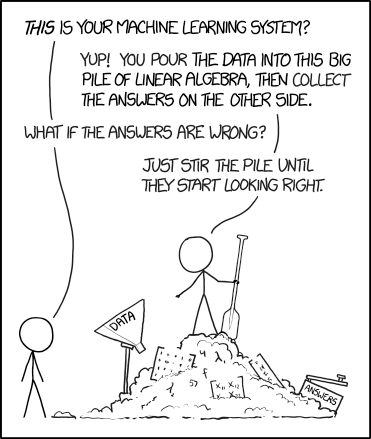